# 目标
- 理解霍夫变换的概念。
- 如何在图像中检测直线
- 涉及的函数：**cv2.HoughLines()**和**cv2.HoughLinesP()**。

# 1. 理论
霍夫变换是一种用于检测可以用数学形式表达的形状的技术，甚至可以检测到轻微断开或变形的形状。本教程中将进行直线的检测。

一条直线可以表示为$y = mx + c$，或者用参数化的形式表示为$\rho = x cos \theta + y sin \theta$，其中$\rho$是原点到直线的垂直距离，$\theta$是该垂直线与水平轴沿逆时针方向的角度（方向取决于坐标系统的表示，这种表示是用于OpenCV中的）。如下图所示：![](./imgs/houghlines1.svg)

因此，如果一条直线经过原点下方，它的$\rho$为正，且$\theta$小于180度。如果直线在原点的上方，角度依然保持小于180度，而是把$\rho$设为负值。任意垂直线的角度为0度，水平线的角度为90度。

下面介绍霍夫变换是如何找到直线的。任意一条直线可以被表示为两个项$(\rho, \theta)$。因此，首先创建一个二维数组作为累加器（用于保存直线的两个参数），并初始化为0。令行表示$\rho$，列表示$\theta$。数组的尺寸取决于所需要的精度。假设角度的精度为1°，那么需要180列。对于$\rho$，最大的距离可能是图像对角线的长度，设精度为1个像素，因此行数是图像对角线的长度。

考虑一幅100x100的图像，并在图像中央有一条水平线。首先取直线的第一个点，能够知道该点$(x,y)$的值。在直线方程中，设$\theta = 0, 1, 2, \dots , 180$然后计算$\rho$的值。对于每一个$(\rho, \theta)$对，将累加器中对应的$(\rho, \theta)$单元加一。

然后取直线的第二个点，做同样的操作，将所得到的$(\rho, \theta)$对应单元的值加一。实际上是在对$(\rho, \theta)$进行投票。对线上的每一点执行该操作，最后得票最多的点就是要检测的直线。其中$\rho$是距离原点的距离，$\theta$是角度，如下图多是：![](imgs/houghlinesdemo.gif)

这就是霍夫变换检测直线的工作方式，这个过程非常简单，可以直接用Numpy直接实现。下面的图像显示了累加结果，较亮的点表示以该点为参数的直线具有更高的可能性。![](imgs/houghlines2.jpg)

# 2. 用OpenCV进行霍夫变换
上面提到的霍夫变换的过程，在OpenCV中被封装在**cv2.HoughLines()**中，该函数直接返回包含$(\rho,\theta)$的数组。$\rho$以像素为单位，$\theta$以弧度为单位。该函数的第一个参数是要输入的二值图像，因此在传入之前要对图像进行阈值操作或Canny边缘检测。第二个和第三个参数是$\rho$和$\theta$的精确度。第四个参数是被认为是直线的“投票数”的阈值。由于票数依赖于直线上点的数量，因此该值表示了需要直线最少需要的点数。

In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

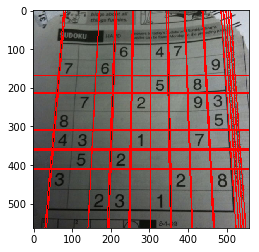

In [2]:
img = cv2.imread('../data/sudoku.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(img[:, :, ::-1])

# 3. 随机霍夫变换
在霍夫变换中，即使只有一条包含两个参数的直线，也要进行大量的计算。随机霍夫变换对霍夫变换进行了优化。该方法并不考虑所有的点，而是只用随机采样的一个子集进行直线检测。由于参与直线检测的点变少，因此需要降低投票数量的阈值。下图比较了霍夫变换和随机霍夫变换的差别。![](imgs/houghlines4.png)

OpenCV中的随机霍夫变换的实现参考了更多资源中给出的论文。OpenCV中提供了函数**cv2.HoughLinesP()**进行随机霍夫变换，该函数包含了两个新的参数：
- **minLineLength** - 线的最小长度，较短的线段会被去除。
- **MaxLineGap** - 被认为是同一条线的线段之间的最大距离。
而且该函数直接返回线段的两个端点，而在霍夫变换中，返回的是直线的两个参数，在随机霍夫变换函数中结果更利用使用。

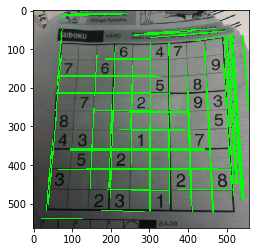

In [3]:
img = cv2.imread('../data/sudoku.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
plt.imshow(img)

# 4. 更多资源
1. Jiri Matas, Charles Galambos, and Josef Kittler. Robust detection of lines using the progressive probabilistic hough transform. Computer Vision and Image Understanding, 78(1):119–137, 2000.
2. [Hough Transform on Wikipedia](http://en.wikipedia.org/wiki/Hough_transform)